In [1]:
import pathlib
import re
import collections

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
data_path = pathlib.Path("./../inputs/data/JEOPARDY_CSV.csv")

In [3]:
df = pd.read_csv(data_path)

In [4]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


## Data info

In [5]:
print("~~~~~~~data info~~~~~~~")
print(df.info())

### Find number of nulls in data
print("\n\n~~~~~~~Number of missing values in each columns~~~~~~~")
print(df.isna().sum(axis=0))

~~~~~~~data info~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Show Number  216930 non-null  int64 
 1    Air Date    216930 non-null  object
 2    Round       216930 non-null  object
 3    Category    216930 non-null  object
 4    Value       216930 non-null  object
 5    Question    216930 non-null  object
 6    Answer      216928 non-null  object
dtypes: int64(1), object(6)
memory usage: 11.6+ MB
None


~~~~~~~Number of missing values in each columns~~~~~~~
Show Number    0
 Air Date      0
 Round         0
 Category      0
 Value         0
 Question      0
 Answer        2
dtype: int64


In [6]:
## Impute null with empty strings
df.fillna("", inplace=True)

## Convert Air date to datetime
df.loc[:, " Air Date"] = pd.to_datetime(df.loc[:, " Air Date"].values)

### Convert Value to integer
df.loc[:, " Value"] = df.loc[:, " Value"].apply(lambda value: re.sub("[,$]", "", value) if value != "None" else 0).astype(int)

###  Value analysis with air date

/home/siddharth/virtual_environments/stripped_ml_libs/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
<ipython-input-7-a7499c64a13c>:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


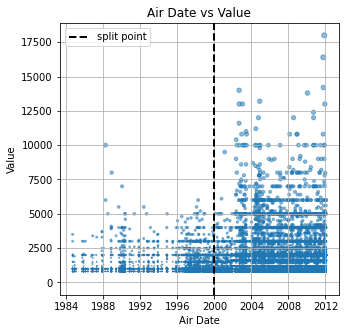

In [7]:
fig = plt.figure(figsize=(5,5))

ax = fig.subplots(1,1)


value, air_date = df.loc[:, " Value"].values, df.loc[:, " Air Date"].values
size = (value - value.mean())/value.std()

ax.scatter(air_date, value, alpha=0.5, s=size)
ax.axvline(np.datetime64("2000-01-01T00:00:00.000000000"), 
           color="black", linewidth=2, linestyle="--", label="split point")

ax.legend()
ax.set_title("Air Date vs Value")
ax.set_xlabel("Air Date")
ax.set_ylabel("Value")
ax.grid()

fig.show()

From the plot above, we hypothise that the there is a slight increase in the value of jeopardy questions after the rough estimate of year 2000. We can run a t-test to confirm the hypothesis

In [8]:
pre_2000_sample = df.loc[df.loc[:," Air Date"]<=np.datetime64("2000-01-01T00:00:00.000000000")," Value"].values
post_2000_sample = df.loc[df.loc[:," Air Date"]>np.datetime64("2000-01-01T00:00:00.000000000")," Value"].values

t_statistic, p_value = stats.ttest_ind(post_2000_sample, pre_2000_sample)
print(f"T-statistic: {t_statistic}, p-value: {p_value}")

T-statistic: 134.92529399336848, p-value: 0.0


From the results above, We reject the null hypothesis: both samples being same and conclude that there is a statistically significant difference between values from pre 2000 and post 2000.


Hence, we can use binary encoding for the air date feature.

## Value analysis with Rounds

In [9]:
print(f"Rounds with count:\n{df.loc[:, ' Round'].value_counts()}")

Rounds with count:
Jeopardy!           107384
Double Jeopardy!    105912
Final Jeopardy!       3631
Tiebreaker               3
Name:  Round, dtype: int64


<ipython-input-10-d409afab51a2>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


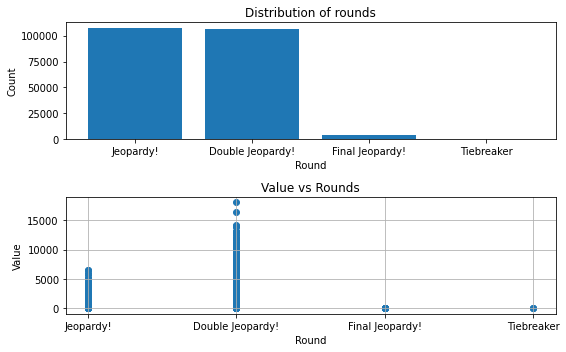

In [10]:
fig = plt.figure(figsize=(8,5))
ax1, ax2 = fig.subplots(2,1)

values, rounds = df.loc[:, " Value"].values, df.loc[:, " Round"].values
rounds_counter = collections.Counter(rounds)

ax1.bar(rounds_counter.keys(), rounds_counter.values())
ax2.scatter(rounds, values)

ax1.set_title("Distribution of rounds")
ax1.set_xlabel("Round")
ax1.set_ylabel("Count")

ax2.set_title("Value vs Rounds")
ax2.set_xlabel("Round")
ax2.set_ylabel("Value")
ax2.grid()

fig.tight_layout()
fig.show()

From the above plots, we get a feel of the rounds distribution. Simple label encoding should suffice for rounds.

## Value analysis with Category

In [11]:
print(df.loc[:, ' Category'].value_counts())

BEFORE & AFTER              547
SCIENCE                     519
LITERATURE                  496
AMERICAN HISTORY            418
POTPOURRI                   401
                           ... 
FAMOUS OBJECTS                1
ANIMATED CHARACTERS           1
ENGLISH LITERARY HISTORY      1
BRITISH WORD ORIGINS          1
SPORTS & MUSIC                1
Name:  Category, Length: 27995, dtype: int64


The features Categories doesn't seem very useful because of large number of categories. Almost as much as the number of data points. We will either drop it, or use it as a part of out text features while training the model.

## Analysis: Questions

In [12]:
## Find word and character len for all questions
top_k = 50
df.loc[:, "q_token_len"] = df.loc[:, " Question"].apply(lambda x: len(x.split(" ")))
df.loc[:, "q_char_len"] = df.loc[:, " Question"].apply(len)

total_words = [word for sent in df.loc[:, " Question"] for word in sent.split()]
question_words_counter = collections.Counter(total_words).most_common(20)
question_words_counter = [f"{word_tuple[0]} -- {word_tuple[1]}"
                          for word_tuple in question_words_counter]

In [13]:
print("Most frequently used 20 words in questions: ")
print("\n".join(question_words_counter))

Most frequently used 20 words in questions: 
the -- 146976
of -- 111389
this -- 99760
in -- 78657
a -- 76257
to -- 48587
& -- 45040
for -- 34659
is -- 33406
was -- 29098
This -- 23660
The -- 23378
In -- 23352
on -- 22279
from -- 17496
with -- 16633
by -- 15530
his -- 15303
as -- 15056
that -- 13937


<ipython-input-14-a43c6a7ae240>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


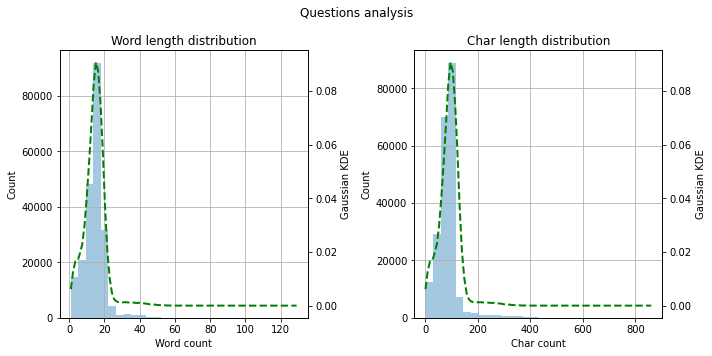

In [14]:
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)


x = np.linspace(df.loc[:, "q_token_len"].min(), df.loc[:, "q_token_len"].max(), 100)
words_kde = stats.gaussian_kde(df.loc[:, "q_token_len"].values)(x)

ax11 = ax1.twinx()
ax1.hist(df.loc[:, "q_token_len"].values, bins=30, alpha=0.4, label="Histogram")
ax11.plot(x, words_kde, linewidth=2, linestyle="--", color="green", label="Gaussian KDE")
ax1.set_title("Word length distribution")
ax1.set_xlabel("Word count")
ax1.set_ylabel("Count")
ax11.set_ylabel("Gaussian KDE")
ax1.grid()



x = np.linspace(df.loc[:, "q_char_len"].min(), df.loc[:, "q_char_len"].max(), 100)
char_kde = stats.gaussian_kde(df.loc[:, "q_char_len"].values)(x)

ax21 = ax2.twinx()
ax2.hist(df.loc[:, "q_char_len"].values, bins=30, alpha=0.4, label="Histogram")
ax21.plot(x, words_kde, linewidth=2, linestyle="--", color="green", label="Gaussian KDE")
ax2.set_title("Char length distribution")
ax2.set_xlabel("Char count")
ax2.set_ylabel("Count")
ax21.set_ylabel("Gaussian KDE")
ax2.grid()

fig.suptitle("Questions analysis")
fig.tight_layout()
fig.show()

## Analysis: Answers

In [15]:
## Find word and character len for all questions
top_k = 50
df.loc[:, "a_token_len"] = df.loc[:, " Answer"].apply(lambda x: len(x.split(" ")))
df.loc[:, "a_char_len"] = df.loc[:, " Answer"].apply(len)

total_words = [word for sent in df.loc[:, " Answer"] for word in sent.split()]
answer_words_counter = collections.Counter(total_words).most_common(20)
answer_words_counter = [f"{word_tuple[0]} -- {word_tuple[1]}"
                          for word_tuple in answer_words_counter]

In [16]:
print("Most frequently used 20 words in Answers: ")
print("\n".join(answer_words_counter))

Most frequently used 20 words in Answers: 
the -- 18887
a -- 11260
The -- 6075
of -- 5020
& -- 3332
John -- 1805
an -- 1478
and -- 1426
New -- 1165
"The -- 1075
George -- 1046
(or -- 925
in -- 846
William -- 764
James -- 742
A -- 698
to -- 650
King -- 631
War -- 613
Henry -- 596


<ipython-input-17-7cf524b9bc60>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


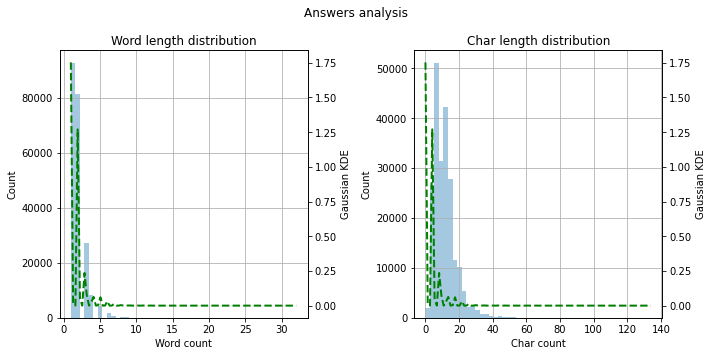

In [17]:
fig = plt.figure(figsize=(10,5))
ax1, ax2 = fig.subplots(1,2)


x = np.linspace(df.loc[:, "a_token_len"].min(), df.loc[:, "a_token_len"].max(), 100)
words_kde = stats.gaussian_kde(df.loc[:, "a_token_len"].values)(x)

ax11 = ax1.twinx()
ax1.hist(df.loc[:, "a_token_len"].values, bins=50, alpha=0.4, label="Histogram")
ax11.plot(x, words_kde, linewidth=2, linestyle="--", color="green", label="Gaussian KDE")
ax1.set_title("Word length distribution")
ax1.set_xlabel("Word count")
ax1.set_ylabel("Count")
ax11.set_ylabel("Gaussian KDE")
ax1.grid()



x = np.linspace(df.loc[:, "a_char_len"].min(), df.loc[:, "a_char_len"].max(), 100)
char_kde = stats.gaussian_kde(df.loc[:, "a_char_len"].values)(x)

ax21 = ax2.twinx()
ax2.hist(df.loc[:, "a_char_len"].values, bins=50, alpha=0.4, label="Histogram")
ax21.plot(x, words_kde, linewidth=2, linestyle="--", color="green", label="Gaussian KDE")
ax2.set_title("Char length distribution")
ax2.set_xlabel("Char count")
ax2.set_ylabel("Count")
ax21.set_ylabel("Gaussian KDE")
ax2.grid()

fig.suptitle("Answers analysis")
fig.tight_layout()
fig.show()

After the analysis, we have a feel of the data. We can use sundry text encoding techniques for ***answers***, ***questions*** and optionally ***Categories***. We will have to use binary encoding with threshold at year 2000 for ***air_date*** and label encoding for ***Rounds***. 

The features ***air_date*** and ***Rounds*** can be transformed and stored, whilst text features ***answers*** and ***questions*** will have to encoded at runtime.